In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

import counts_statistics_qpe as cs
import phase_estimation_functions as qpe
import verification_functions as verif
from densitymatrix import DM
import glob

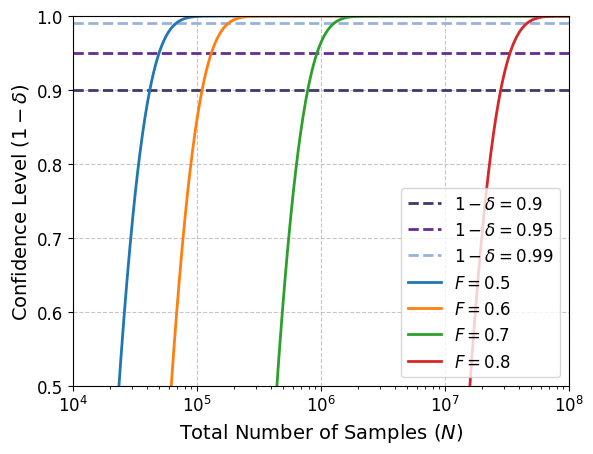

In [2]:
#################### Simulations according to Anu's certification protocol #################
failure_rate = 0.03
n_stab = 4 #It can only be 4 or 16?
x_data = N_total = np.logspace(4, 8, 1000)
y_data = np.zeros((4, len(x_data)))

F = [0.5, 0.6, 0.7, 0.75]
def conf(N_total, n_stab, failure_rate, F):
    m = N_total/(2*n_stab**5*np.log(n_stab))
    c = (n_stab*(1-F-2*n_stab*failure_rate)/2)**2
    confidence_level = 1-n_stab**(1-2*m*c/3)
    return confidence_level

for i, fidelity in enumerate(F):
    y_data[i] = conf(N_total, n_stab, failure_rate, fidelity)

colors = ["#99B2DD","#662C91","#40376E","#E0BE36"]
plt.errorbar(x_data, y_data[0], label=r"$F=0.5$", linewidth=2)
plt.errorbar(x_data, y_data[1], label=r"$F=0.6$", linewidth=2)
plt.errorbar(x_data, y_data[2], label=r"$F=0.7$", linewidth=2)
plt.errorbar(x_data, y_data[3], label=r"$F=0.8$", linewidth=2)
plt.axhline(0.9, linestyle='--', label=r"$1-\delta = 0.9$", color = colors[2], linewidth=2)
plt.axhline(0.95, linestyle='--', label=r"$1-\delta = 0.95$", color = colors[1], linewidth=2)
plt.axhline(0.99, linestyle='--', label=r"$1-\delta = 0.99$", color = colors[0], linewidth=2)

plt.xlabel(r"Total Number of Samples ($N$)", fontsize=14)  # X-axis label
plt.ylabel(r"Confidence Level $(1-\delta)$", fontsize=14)  # Y-axis label
plt.ylim(0.5, 1)
plt.xlim(1e4, 1e8)
plt.xscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
# plt.savefig(rf"C:\Users\LauraMartins\Documents\PhD\Lab\Figures&Presentations\Figures_QPE\certif_sim_F.pdf")
plt.show()

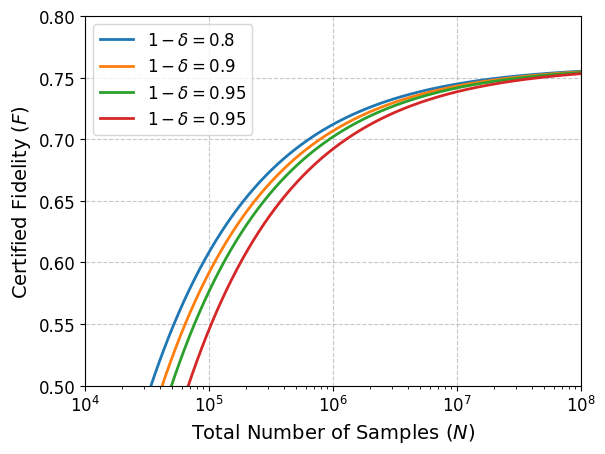

In [3]:
confidence_level = [0.8, 0.9, 0.95, 0.99]

def get_fidelity_bound(N_total, failure_rate, confidence_level):
    m = N_total/(2*n_stab**5*np.log(n_stab))
    c = 3*(1-np.log(1-confidence_level)/np.log(n_stab))/(2*m)
    fidelity_bound = 1 - 2*np.sqrt(c)/(n_stab)-2*n_stab*failure_rate

    return fidelity_bound

for i, conf in enumerate(confidence_level):
    y_data[i] = get_fidelity_bound(N_total, failure_rate, conf)

colors = ["#99B2DD","#662C91","#40376E","#E0BE36"]
plt.errorbar(x_data, y_data[0], label=r"$1-\delta = 0.8$", linewidth=2)
plt.errorbar(x_data, y_data[1], label=r"$1-\delta = 0.9$", linewidth=2)
plt.errorbar(x_data, y_data[2], label=r"$1-\delta = 0.95$", linewidth=2)
plt.errorbar(x_data, y_data[3], label=r"$1-\delta = 0.95$", linewidth=2)

plt.xlabel(r"Total Number of Samples ($N$)", fontsize=14)  # X-axis label
plt.ylabel(r"Certified Fidelity ($F$)", fontsize=14)  # Y-axis label
plt.ylim(0.5, 0.8)
plt.xlim(1e4, 1e8)
plt.xscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize = 12)
plt.grid(True, linestyle='--', alpha=0.7)
# plt.savefig(rf"C:\Users\LauraMartins\Documents\PhD\Lab\Figures&Presentations\Figures_QPE\certif_sim_delta.pdf")
plt.show()

In [3]:
"""
START DATA ANALYSIS
"""
####################### VERIFICATION ANALYSIS #################
data_dir = r"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\GHZ\with_Certification"
os.chdir(data_dir)
filenames  = [i for i in glob.glob("COMPLETE*")]
n_qubits = 4
input_state = "GHZ" #or GHZ # This will specify in which folder we want to save the figures

def sorting_index(filename: str):
    x, y = filename[:-len(".txt")].split("_")[1:]
    return int(y), int(x)

# Defining the stabilizers we want to stabilize and respective signs
stabilizers = [ "iiii", "zzii", "izzi", "iizz", "xxxx", "zizi", "iziz", "zzzz", "xyyx", "yxyx", "xxyy", "yyxx", "ziiz", "yxxy", "xyxy", "yyyy"]
#stabilizers = ["xxxx", "yyxx", "xyyx", "xxyy"]
stab_sign = [1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , -1 , -1 , -1 , -1 , 1 , -1 , -1 , 1 ]
#stab_sign = [1 , -1, -1 , -1]
STABILIZER_TO_INDEX = {stab: i for i, stab in enumerate(stabilizers)}      

In [ ]:
"""
Loading the data files
Uncomment if ["n_samples", "n_samples_error", "p_pass", "p_pass_error"] txt files haven't been generated
Gets the p_pass list the counts in data_dirs folder

Set verif_type = "stats_verif" to generate the evolution of the failure rate with 16 stabilizers
OR Set verif_type = "stats_originalverif" to generate the evolution of the failure rate with 4 stabilizers
""" 
verif_type = "stats_verif" # You should switch to "stats_originalverif" for the 4 original stabilizers

for index, file in enumerate(filenames):
    file_dir = f"{data_dir}\{file}\counts"
    os.chdir(file_dir)
    files = [i for i in glob.glob("ABCD=*.txt")]
    files.sort(key = sorting_index)

    n_rounds = sorting_index(files[-1])[0] + 1
    ROUND_TO_FILES = defaultdict(list)
    for f in files:
         round_ = sorting_index(f)[0]
         ROUND_TO_FILES[round_].append(f)

    for i in tqdm(range(n_rounds)):
        writting_dir = f"{data_dir}\{file}\{verif_type}\\v_round={i}"
        os.makedirs(f"{writting_dir}", exist_ok=True)

        stats = cs.Operartors_Statistics(n_qubits, stabilizers, stab_sign, STABILIZER_TO_INDEX, ROUND_TO_FILES[i], file_dir)
        samples_evolution = np.arange(1, stats.n_loops+1, 1)
        p_pass_list, n_samples_list = stats.get_pass_prob_evolution(samples_evolution, writting_dir)
        

100%|██████████| 30/30 [1:17:49<00:00, 155.64s/it]


In [5]:
"""
Reading and analysing the verification stats files

Set verif_type = "stats_verif" to load the evolution of the failure rate with 16 stabilizers
OR Set verif_type = "stats_originalverif" to load the evolution of the failure rate with 4 stabilizers
""" 

verif_type = "stats_verif" # You should switch to "stats_originalverif" for the 4 original stabilizers

n_rounds=30
qtys = ["n_samples", "n_samples_error", "p_pass", "p_pass_error"]
samples_evolution = np.arange(1, 1e4, 1)
p_fail_evolution = np.zeros((len(filenames), n_rounds, int(1e4)))
n_samples_evolution = np.zeros((len(filenames), n_rounds, int(1e4)))


for index, file in enumerate(filenames):
    for i in tqdm(range(n_rounds)):
        stats_dir = f"{data_dir}\{file}\{verif_type}\\v_round={i}"
        for qty in qtys:
            with open(f"{stats_dir}\\{qty}.txt", "r") as f:
                # It reads each qtys.txt file and writes its content as variable qtys[i]_list;
                # eg.: p_pass_list and n_samples_list used bellow in the cell are defined here
                var_name = f"{qty}_list"
                locals()[var_name] = list(map(float,list(f.read().strip("[").strip("]").split(","))))
        p_fail_evolution[index][i] = 1 - np.array(p_pass_list, dtype=float)
        n_samples_evolution[index][i] = np.array(n_samples_list, dtype=float)

100%|██████████| 30/30 [00:01<00:00, 24.12it/s]


C:\Users\QILIP6\AppData\Local\Temp\ipykernel_41332\2275667803.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


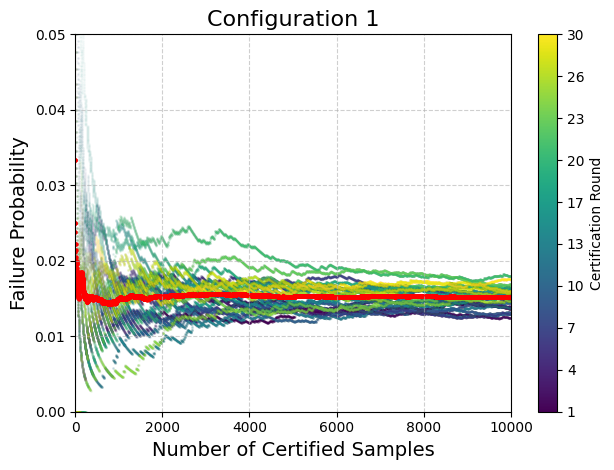

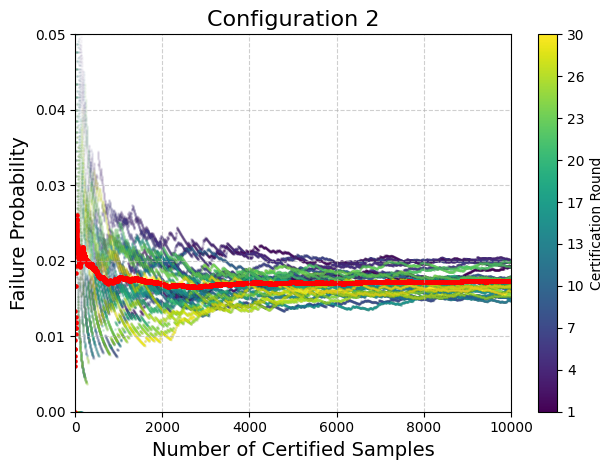

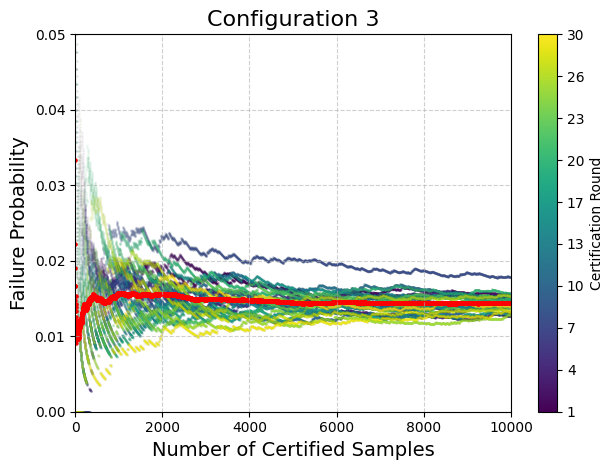

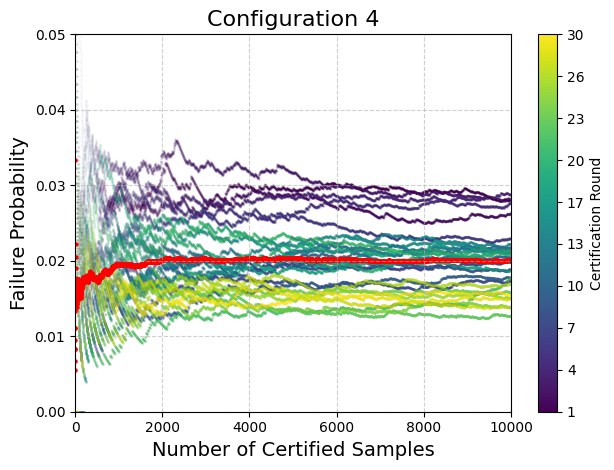

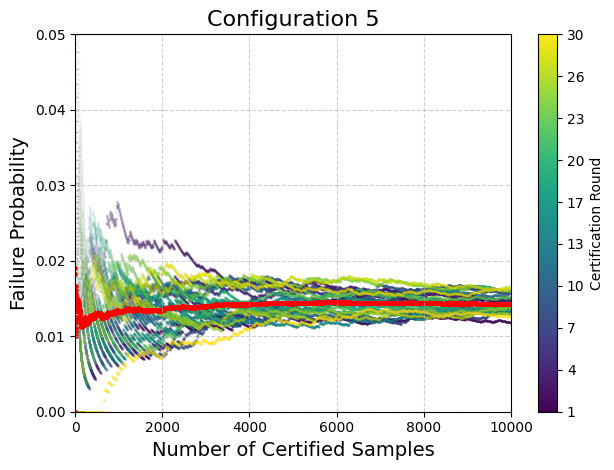

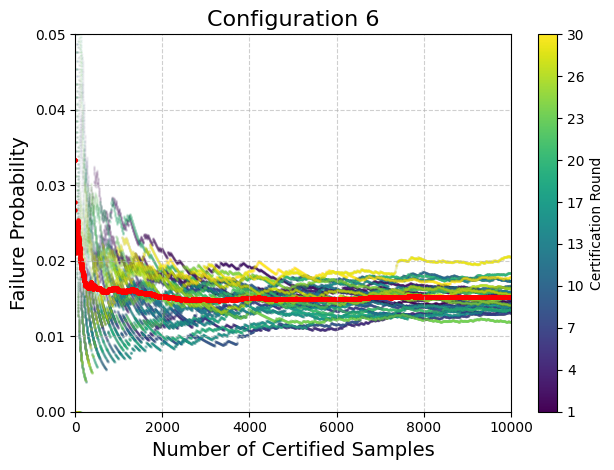

Mean Final failure probabilities [0.0152, 0.0173, 0.0144, 0.0201, 0.0142, 0.0152]


In [6]:
cmap = mpl.colormaps['viridis']
colors = cmap(np.linspace(0, 1, n_rounds))

############# Plotting the failure rate ##############
final_p_fail_mean = []
for index, file in enumerate(filenames):
    for i in range(n_rounds):
        ### Plotting the failure rate evolution for each verification round
        ### There is something weird with the dimensions
        x_data = n_samples_evolution[index][i]
        y_data = p_fail_evolution[index][i]

        plt.scatter(x_data, y_data,
                    s = 1,  # Increase scatter size
                    alpha = 0.03,  # Reduce point opacity for clarity
                    label = f"Dataset {i + 1}",
                    color = colors[i])  # Dynamic legend labels
        
    final_p_fail_mean.append(np.round(np.average(p_fail_evolution[index], axis = 0)[-1], 4))

    ### Plotting the mean failure rate evolution over all verification rounds
    p_fail_average_evolution = np.average(p_fail_evolution[index], axis=0)
    y_data_average = p_fail_average_evolution[:-1]
    x_data = np.arange(0, len(y_data_average))
    plt.scatter(x_data, y_data_average,
                s=5,  # Increase scatter size
                alpha=1,  # Reduce point opacity for clarity
                color = 'r',
                label=f"Dataset {i + 1}")  # Dynamic legend labels

    # Customize plot
    # Create a ScalarMappable to serve as the colorbar
    norm = mpl.colors.Normalize(vmin=1, vmax=n_rounds)  # Normalize to match the rounds
    sm = mpl.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])  # Required for the colorbar

    # Add the colorbar
    cbar = plt.colorbar(sm)
    cbar.set_label("Certification Round")  # Label for colorbar
    cbar.set_ticks(np.linspace(1, n_rounds, min(n_rounds, 10)))  # Adjust ticks for clarity
    cbar.set_ticklabels([f"{int(i)}" for i in np.linspace(1, n_rounds, min(n_rounds, 10))])  # Custom labels

    plt.xlim(0, 10000)  # Refine x-axis limits
    plt.ylim(0, 0.05)
    # plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)  # Light gridlines
    plt.xlabel("Number of Certified Samples", fontsize=14)  # X-axis label
    plt.ylabel("Failure Probability", fontsize=14)  # Y-axis label
    plt.title(f"Configuration {index+1}", fontsize=16)  # Plot title
    plt.tight_layout()  # Avoid clipping
    # plt.savefig(rf"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\Plus\with_Certification\Plus_OG_QSC_failure_evol_r={index+1}")
    plt.show()

print("Mean Final failure probabilities", final_p_fail_mean)

In [31]:
# significance_data = []
# lamb = 1/2
# delta = 0.01
all_ysols = {}

confidence_level = 0.3
verif_anu = verif.AnuGraph(n_qubits = n_qubits, n_stabilizers = len(stabilizers))

for index, file in enumerate(filenames):
    all_ysols[file] = []
    for i in tqdm(range(n_rounds)):
        x_data = samples_evolution
        y_sols = [
                    # verif.get_epsilon(lamb, delta, xval, pval, 0.05) # Method for the MBQC paper
                    verif_anu.get_fidelity_bound(xval, pval, confidence_level) # Method for Anu's graph state verification paper
                    for xval, pval in zip(x_data, p_fail_evolution[index][i][:-1])
                 ]

        all_ysols[file].append(y_sols)

100%|██████████| 30/30 [00:01<00:00, 16.81it/s]


In [11]:
# import pickle
# with open(fr"{data_dir}\all_epsilon_data_Anu.pickle", "rb") as f:
#     data = pickle.load(f)
# all_ysols = data

# with open("all_epsilon_data.pickle", "wb") as f:
#     pickle.dump(all_epsilon_data, f)

In [42]:
all_epsilon_data = {}
for index, file in enumerate(filenames):
    all_epsilon_data[file] = []
    min_len_list = []
    for i in tqdm(range(n_rounds)):
        x_data = []
        y_data = []
        for sol, x in zip(all_ysols[file][i], samples_evolution):
            x_data.append(x)
            y_data.append(sol)

        ### The lines commented below can show the plot for the MBQC method
        # for sol, x in zip(all_ysols[file][i], samples_evolution):
        #     if sol.success:
        #         assert 0 <= sol.x <= 1
        #         x_data.append(x)
        #         y_data.append(sol.x)
            # else:
                # print(f"Failed for {file}, round {i}")
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        all_epsilon_data[file].append((x_data, y_data))

        plt.scatter(x_data, y_data,
                    s = 1,  # Increase scatter size
                    alpha = 0.01,  # Reduce point opacity for clarity
                    label = f"Dataset {i + 1}",
                    color = 'g')  # Dynamic legend labels

# Add axis labels, title, and legend
    plt.xlabel("Number of Verified Samples", fontsize=14)  # X-axis label
    plt.ylabel(r"$\epsilon$", fontsize=14)  # Y-axis label
    plt.ylim(0, 1)
    plt.xlim(0, 1e4)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(r"$\epsilon$ vs # Verification Rounds (99% Confidence Level)")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    # plt.savefig(rf"C:\Users\Experience\Desktop\Multipartite Entanglement Experiment\Data\Figures\QPE\{input_state}\verification_epsilon_evol_r={index+1}", dpi=300)
    plt.show()

# import pickle
# with open("all_epsilon_data_Bell.pickle", "wb") as f:
#     pickle.dump(all_epsilon_data, f)

  0%|          | 0/30 [00:00<?, ?it/s]


NameError: name 'all_ysols' is not defined

c:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Analysis_code\QuantumPhaseEstimation\Laura_test\verification_functions.py:15: RuntimeWarning: divide by zero encountered in divide
  return (k / (N * nu * epsilon)) * (lamb * np.sqrt(2 * nu) + 1) - lamb * np.sqrt(2 * nu)
c:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Analysis_code\QuantumPhaseEstimation\Laura_test\verification_functions.py:31: RuntimeWarning: divide by zero encountered in divide
  N_min = ((np.log(1/delta) + 4*lamb*nu**2)/epsilon)*((lamb*np.sqrt(2*nu) + r)/(lamb*nu*(1 - r)))**2
c:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Analysis_code\QuantumPhaseEstimation\Laura_test\verification_functions.py:31: RuntimeWarning: invalid value encountered in divide
  N_min = ((np.log(1/delta) + 4*lamb*nu**2)/epsilon)*((lamb*np.sqrt(2*nu) + r)/(lamb*nu*(1 - r)))**2


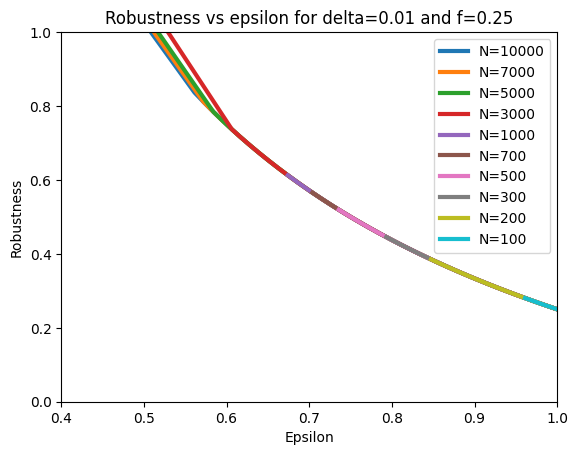

In [43]:
### This plot should show the space (r, epsilon) for which N_test samples with a failure_rate=f_rate can certify a GHZ states with 99% confidence level.
### If the plot is empty there are no solutions and we cannot certify anything
N_test = [10000, 7000, 5000, 3000, 1000, 700, 500, 300, 200, 100, 50]
x_test = np.linspace(0, 1, 10000)
lamb = 0.5
f_rate=0.25

for i in range(10):
    y_test = verif.r_func(x_test, lamb, f_rate, N_test[i])
    cond = N_test[i] - verif.N_bound(x_test, 0.5, 0.01, f_rate, N_test[i])
    plt.plot(x_test[cond >= 0], y_test[cond >= 0], label = f"N={N_test[i]}", linewidth = 3)

plt.ylim(0, 1)
plt.xlim(0.4, 1)
plt.ylabel("Robustness")
plt.xlabel("Epsilon")
plt.title(f"Robustness vs epsilon for delta=0.01 and f=0.25")
plt.legend()
plt.show()

In [26]:
### To save the data in a dictionary so we don't have to run this calculus again
import pickle

with open("all_epsilon_data.pickle", "wb") as f:
    pickle.dump(all_epsilon_data, f)

# plt.plot(*all_epsilon_data['COMPLETE_QPE_FIRST_RUN'][1])

In [ ]:
import pickle

# with open("all_epsilon_data.pickle", "wb") as f:
#     pickle.dump(all_epsilon_data, f)

# ### To load that same data
# with open(fr"{data_dir}\all_epsilon_data.pickle", "rb") as f:
#     data = pickle.load(f)